### UNSUPERVISED MACHINE LEARNING FOR THE CLASSIFICATION OF ASTROPHYSICAL X-RAY SOURCES

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import euclidean, cdist
from scipy.special import softmax
import matplotlib.pyplot as plt

In [2]:
sim_data = pd.read_csv('./cluster_data/sim_new_xray.csv')

In [5]:
len(np.unique(sim_data['name']))

15248

In [15]:
sim_df_clean = sim_data.copy(deep=True).fillna({'main_type': 'NaN'})

In [16]:
pd.set_option('display.max_rows', 1000)
sim_df_clean.main_type.value_counts()

NaN                     9466
X                       2853
QSO                     2426
Orion_V*                2057
YSO                     2047
Star                    1706
HMXB                     903
AGN                      644
Seyfert_1                632
TTau*                    632
LMXB                     509
GlCl                     444
Candidate_XB*            434
XB                       380
Galaxy                   316
AGN_Candidate            266
Seyfert_2                237
PartofG                  232
Radio                    207
ULX?                     174
Candidate_YSO            174
BYDra                    163
SB*                      157
CataclyV*                152
Em*                      144
BLLac                    130
Pulsar                   129
SNR                      125
WR*                      117
EB*                      100
V*                        90
ULX                       88
LensedQ                   87
GinCl                     78
LINER         

In [7]:
features = ['hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_ratio_b', 'var_prob_h', 'var_ratio_h', 'var_prob_s', 'var_ratio_s', 'var_newq_b']

features_lognorm = ['bb_kt', 'var_ratio_b', 'var_ratio_s', 'var_newq_b']

features_norm = ['powlaw_gamma']

X = sim_df_clean.copy(deep=True).to_numpy()

In [8]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [9]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(sim_df_clean, X, feature, True)
        
for feature in features_norm:
    X = lognorm(sim_df_clean, X, feature, False)

In [10]:
s_df = pd.DataFrame(X, columns=sim_df_clean.columns)

In [12]:
def Mahalanobis(x, covariance_matrix, mean):

    x = np.array(x)
    mean = np.array(mean)
    covariance_matrix = np.array(covariance_matrix)

    t1 = (x-mean)
    print(f'Term 1 {t1}')

    icov = np.linalg.inv(covariance_matrix)
    print(f'Inverse covariance {icov}')

    t2 = (x.transpose()-mean.transpose())
    print(f'Term 2 {t2}')

    mahal = t1.dot(icov.dot(t2))

    #return (x-mean)*np.linalg.inv(covariance_matrix).dot(x.transpose()-mean.transpose())
    return mahal

In [37]:
def create_summary_tables(df):
    data_n = df.copy(deep=True)
    count_obs = data_n.groupby(['main_type']).size()
    df_n = pd.concat([count_obs], axis=1)
    df_n = df_n.rename(columns={0:'size'})
    return df_n

def softmin(x):
    return np.exp(-np.abs(x))/sum(np.exp(-np.abs(x)))
    
def frequent_types(df, n, uks):
    if uks:
        df = df[(df.main_type != 'NaN') & ~(df.main_type.isin(uks))]
    else:
        df = df[df.main_type != 'NaN']
    count_obs = df.groupby(['main_type']).size()
    count_obs_df = count_obs.reset_index()
    count_obs_df = count_obs_df.rename(columns={0:'size'})
    quer = count_obs_df.sort_values(by='size', ascending=False).head(n)
    ltypes = np.unique(quer.main_type)
    return ltypes

def gen_nan_probs(cl, features, uks=[], mean=True, distance='mahalanobis'):
    if uks:
        cl_nan = cl[(cl.main_type == 'NaN') | cl.main_type.isin(uks)]
    else:
        cl_nan = cl[cl.main_type == 'NaN']

    cl_types_desc = cl_nan[features]
    ltypes = frequent_types(cl, 5, uks=uks)
    types_comp = []
    types_prob = []
    for i, row in cl_types_desc.iterrows():
        r_np = row.to_numpy().reshape(1, -1)

        mdists = []
        for t in ltypes:
            cl_type = cl[cl.main_type == t]
            cl_type_desc = cl_type[features]
            cltd_np = cl_type_desc.to_numpy()
            
            if distance == 'euclidean':
                d2t = cdist(r_np, cltd_np, metric='euclidean')
            elif distance == 'mahalanobis':
                #print(cltd_np.astype(float))
                V = np.cov(cltd_np.astype(float).T)
                
                IV = np.linalg.inv(V)
                d2t = cdist(r_np, cltd_np, metric='mahalanobis', VI=IV)
            
            if mean:
                d2t_mean = np.mean(d2t)
            else:
                d2t_mean = np.median(d2t)

            mdists.append(d2t_mean)

        scaler = MinMaxScaler()
        mdistsn = np.asarray(mdists).reshape(-1, 1)
        #mdistsn = scaler.fit_transform(mdistsn)
        mdistsn = mdistsn.ravel()
        sm_probs = softmin(mdistsn)
        types_prob.append(sm_probs)
        t_amax = np.argmax(sm_probs)
        types_comp.append(ltypes[t_amax])

    #print(cl_nan.name.to_numpy(), np.array(types_prob), types_comp)
    out_l = pd.DataFrame(cl_nan[['name', 'obsid'] + features])
    out_l['main_type'] = types_comp
    for i, t in enumerate(ltypes):
        tarray_probs = np.vstack(types_prob)
        out_l[t] = tarray_probs[:, i]
        
    return out_l

In [58]:
n = 4
uks = ['Star', 'X', 'Unknown']
cl_n = s_df[s_df.cluster == n]
#cl_n_nans = pd.read_csv(f'mahalanobis_labeled/cl{n}_mean.csv', index_col=0)
cl_n_nans = gen_nan_probs(cl_n, features, uks=uks, mean=True, distance='mahalanobis')
cl_n_nans.head(10)

,name,obsid,hard_hm,hard_hs,hard_ms,powlaw_gamma,bb_kt,var_prob_b,var_ratio_b,var_prob_h,var_ratio_h,var_prob_s,var_ratio_s,var_newq_b,main_type,HMXB,Orion_V*,QSO,Seyfert_2,YSO
9,2CXO J000047.6-551937,7061,-0.043723,-0.438476,-0.393504,0.453871,0.102517,0.0362,0.729312,0.053602,0.00032,0.04187,0.787952,0.061408,QSO,0.001748,0.121715,0.678783,0.173646,0.024107
49,2CXO J000917.2-321938,5783,0.595878,0.92817,0.742036,0.373291,0.276668,0.039011,0.744675,0.045137,0.000652,0.504674,0.88304,0.061408,Seyfert_2,0.393957,0.059813,0.006604,0.395555,0.144072
85,2CXO J001331.8-272206,5038,0.321049,0.500937,0.212367,0.374526,0.251374,0.079578,0.795981,0.070316,0.003804,0.564297,0.869001,0.061387,HMXB,0.427472,0.064725,0.179102,0.140232,0.188469
93,2CXO J001346.6-493923,13471,0.147408,-0.258588,-0.382261,0.435707,0.119324,0.048858,0.70329,0.04713,0.0014,0.174811,0.822362,0.061408,QSO,0.000715,0.074768,0.568353,0.340624,0.015540
100,2CXO J001359.9-390303,2255,-0.013741,-0.484697,-0.467208,0.466303,0.090087,0.043606,0.691662,0.116473,0.007374,0.080395,0.809373,0.061408,QSO,0.001061,0.120748,0.592175,0.262501,0.023515
123,2CXO J001455.0-494947,13471,0.522174,0.808245,0.489694,0.390896,0.267222,0.161044,0.831098,0.076435,0.00437,0.53215,0.872131,0.061501,HMXB,0.320277,0.204166,0.010192,0.172619,0.292747
131,2CXO J001524.0+171401,10547,0.510931,0.765771,0.413492,0.343821,0.296389,0.07192,0.793392,0.136896,0.015923,0.391571,0.860912,0.061415,HMXB,0.331761,0.117485,0.161996,0.189870,0.198887
153,2CXO J001817.8+301332,10231,0.356027,0.539663,0.226109,0.375381,0.25651,0.041325,0.66685,0.056723,0.000747,0.474777,0.874259,0.061408,HMXB,0.367587,0.101754,0.258471,0.098693,0.173495
251,2CXO J002402.0+043126,7914,0.262336,0.619613,0.422236,0.406479,0.239859,0.096695,0.788014,0.137663,0.008969,0.831843,0.894998,0.061408,HMXB,0.433787,0.063104,0.078242,0.121658,0.303209
334,2CXO J002443.3-721825,2738,0.091193,-0.372267,-0.438476,0.432229,0.077389,0.055316,0.746452,0.069029,0.004137,0.952653,0.887791,0.061408,Seyfert_2,0.000205,0.018638,0.142472,0.834277,0.004407


***Note:*** *We have a problem here. Since there are classes with not enough observations, we mostly have a singular matrix (observations < features) when computing the covariance matrix, making impossible to compute the Mahalanobis distance. We have two alternatives here:*

1. Reduce number of cluster to maximize representation in classes per cluster.
2. Use the euclidian distance.

The second one could have potential problems for comparability, given the different metrics, but let's go with that to experiment.

In [69]:
create_summary_tables(s_df[s_df.cluster == 5]).sort_values(by='size', ascending=False).head(10)

,size
main_type,
NaN,1766
YSO,667
Orion_V*,618
X,505
Star,347
QSO,329
HMXB,261
TTau*,202
Seyfert_1,131


<AxesSubplot:>

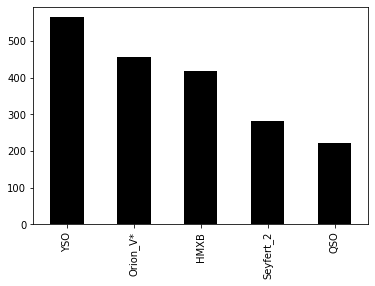

In [60]:
cl_n_nans['main_type'].value_counts().plot.bar(color='black')

In [61]:
cl_n_nans.to_csv('class_data/cl{}.csv'.format(n))